编写函数inter_cross实现交叉操作

In [1]:
def inter_cross(indiv_list, gene_list, prob):
    """ 对染色体进行交叉操作 """
    gene_num = len(gene_list[0])
    ready_index = list(range(len(gene_list)))
    while len(ready_index) >= 2:
        d1 = random.choice(ready_index)
        ready_index.remove(d1)
        d2 = random.choice(ready_index)
        ready_index.remove(d2)
        if np.random.uniform(0, 1) <= prob:
            loc = random.choice(range(gene_num))
            print(d1,d2,"exchange loc --> ",loc)
            # 对数据做交叉操作
            if indiv_list is not None:
                tmp = indiv_list[d1].iloc[:,loc]
                indiv_list[d1].iloc[:,loc] = indiv_list[d2].iloc[:,loc]
                indiv_list[d2].iloc[:,loc] = tmp
                
            # 对基因型做交叉操作
            tmp = gene_list[d1][loc]
            gene_list[d1][loc] = gene_list[d2][loc]
            gene_list[d2][loc] = tmp

假设有两个个体，它们的基因组分别为[g(add,X1,X2),g(log,X1),g(add,g(log,X2),X3)]、[g(pow2,X3),g(add,g(inv,X1),g(log,X2)),g(log,g(tanh,X4))]

绘制对应的二叉树组

In [2]:
def plot_tree(feature_string, title=None, node_size=5000, font_size=18):
    my_dict = transform(feature_string)
    root, labels, _ = bitree(my_dict, len(my_dict)-1, 0, labels={})
    graph = nx.Graph()
    graph, pos = create_graph(graph, root)
    nx.draw_networkx(graph, pos, node_size=node_size,width=2,node_color='black',font_color='white',font_size=font_size,with_labels=True,labels=labels)
    plt.axis('off')
    if title is not None:
        plt.title(title)

In [3]:
def transform(feature_string):
    my_dict={}
    pattern = r'g\([^\(\)]*\)'
    so = re.search(pattern, feature_string)
    while so:
        start, end = so.span()
        key = len(my_dict)
        my_dict[key]=so.group()
        feature_string = feature_string[0:start]+'<'+str(key)+'>'+feature_string[end:]
        so = re.search(pattern, feature_string)
    return my_dict

In [4]:
def bitree(mapping, start_no, index=0, labels={}):
    name, left, right = parse(mapping[start_no])
    if left is not None:
        if type(left) == int:
            left_node, s_labels, max_index = bitree(mapping, left, index+1, labels)
            labels = s_labels
        else:
            left_node = Node(index+1, left)
            labels[index+1] = left
            max_index = index+1
    else:
        left_node = None
    
    if right is not None:
        if type(right) == int:
            right_node, s_labels, max_index = bitree(mapping, right, max_index+1, labels)
            labels = s_labels
        else:
            right_node = Node(max_index+1, right)
            labels[max_index+1] = right
            max_index = max_index+1
    else:
        right_node = None
        
    labels[index] = name
    return Node(index, name, left_node, right_node) ,labels, max_index

In [5]:
def parse(group_unit):
    tmp = group_unit.lstrip("g(").rstrip(")").split(',')
    tmp = tmp + [None] if len(tmp) == 2 else tmp
    return [int(x[1:-1]) if x is not None and re.match(r'<[0-9]+>',x) else x for x in tmp]

In [6]:
class Node:
    def __init__(self, value, label, left=None, right=None):
        self.value = value
        self.label = label
        self.left = left  
        self.right = right

In [7]:
def create_graph(G, node, pos={}, x=0, y=0, layer=1):
    pos[node.value] = (x, y)
    if node.left:
        G.add_edge(node.value, node.left.value)
        l_x, l_y = x - 1 / layer, y - 1
        l_layer = layer + 1
        create_graph(G, node.left, x=l_x, y=l_y, pos=pos, layer=l_layer)
    if node.right:
        G.add_edge(node.value, node.right.value)
        r_x, r_y = x + 1 / layer, y - 1
        r_layer = layer + 1
        create_graph(G, node.right, x=r_x, y=r_y, pos=pos, layer=r_layer)
    return G, pos

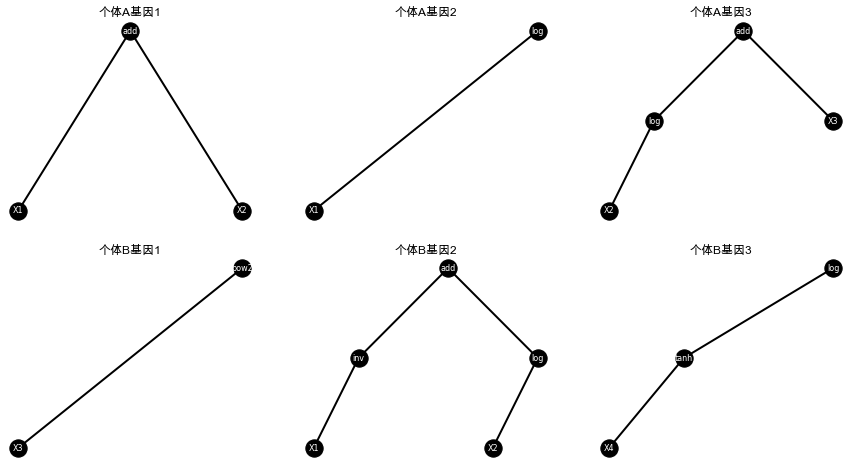

In [18]:
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import re
matplotlib.rcParams['font.family'] = 'Arial Unicode MS'

A = ['g(add,X1,X2)','g(log,X1)','g(add,g(log,X2),X3)']
B = ['g(pow2,X3)','g(add,g(inv,X1),g(log,X2))','g(log,g(tanh,X4))']
counter = 1
titles=['个体A基因1','个体A基因2','个体A基因3','个体B基因1','个体B基因2','个体B基因3']
plt.figure(figsize=(15,8))
for e in A+B:
    plt.subplot(2,3,counter)
    plot_tree(e, title=titles[counter - 1],node_size=300,font_size=8)
    counter = counter + 1
plt.show()

使用inter_cross函数进行交叉操作

1 0 exchange loc -->  0


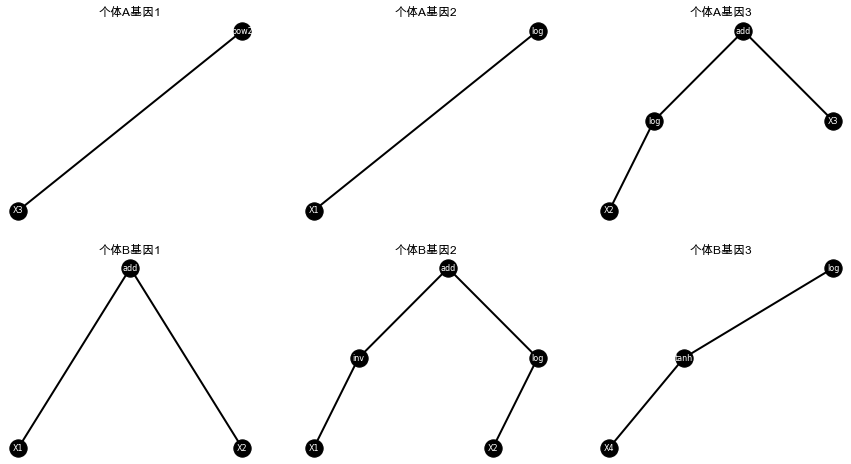

In [9]:
import random
import numpy as np

inter_cross(None, [A,B], 1)
counter = 1
titles=['个体A基因1','个体A基因2','个体A基因3','个体B基因1','个体B基因2','个体B基因3']
plt.figure(figsize=(15,8))
for e in A+B:
    plt.subplot(2,3,counter)
    plot_tree(e, title=titles[counter - 1],node_size=300,font_size=8)
    counter = counter + 1
plt.show()
# 0 1 exchange loc -->  1

编写函数mutate实现变异操作

In [10]:
def mutate(indiv_list, gene_list, prob, input_data, featureIdx, nMax=10):
    gene_num = len(gene_list[0])
    ready_index = list(range(len(gene_list)))
    for i in ready_index:
        if np.random.uniform(0, 1) <= prob:
            loc = random.choice(range(gene_num))
            print(i,"mutate on --> ",loc)
            tmp = random_get_tree(input_data, featureIdx, nMax) 
            if indiv_list is not None:
                indiv_list[i].iloc[:,loc] = tmp['f_value']
            gene_list[i][loc] = tmp['tree_exp']

对于个体A，使用mutate实现变异，当发生变异时，绘制其变异前后二叉树组图。为了显示变异的效果，这里将突变概率设置为0.9

In [11]:
def random_get_tree(input_data,featureIdx,nMax=10):
    """ 
    从原始数据特征中，随机获取特征表达树  
    featureIdx: 原始特征的下标数值，最小从1开始
    nMax:一次最多从特征中可放回抽样次数，默认为10
    """
    data = pd.DataFrame({"X"+str(e):input_data.iloc[:,(e-1)].values for e in featureIdx})
    
    # 随机抽取N个特征下标
    N = random.choice(range(2,nMax+1))
    
    # 随机决定是使用满二叉树还是偏二叉树
    if random.choice([0,1]) == 1:
        # 选择满二叉树
        select_feature_index = [random.choice(featureIdx) for i in range(N)]+[0]*int(2**np.ceil(np.log2(N)) - N)
        random.shuffle(select_feature_index)
        select_feature_index = ['data.X'+str(e)+".values" if e> 0 else '0' for e in select_feature_index]
        tree_exp = gen_full_tree_exp(select_feature_index)
    else:
        # 选择偏二叉树
        select_feature_index = ['data.X'+str(e)+".values" for e in [random.choice(featureIdx) for i in range(N)]]
        tree_exp =  gen_side_tree_exp(select_feature_index)
    return {"f_value":eval(tree_exp),"tree_exp":tree_exp.replace("data.","").replace(".values","")}

In [12]:
#构建偏二叉树，并生成数学表达式
def gen_side_tree_exp(var_flag_array):
    if len(var_flag_array) == 1:
        return add_one_group(var_flag_array[0])
    else:
        var_flag_array[1] = 'g('+random.choice(two_group)+','+add_one_group(var_flag_array[0])+','+add_one_group(var_flag_array[1])+')'
        del var_flag_array[0]
        return gen_side_tree_exp(var_flag_array)

In [13]:
# 构建满二叉树，并生成数学表达式
def gen_full_tree_exp(var_flag_array):
    half_n = len(var_flag_array)//2
    middle_array = []
    for i in range(half_n):
        if var_flag_array[i] == '0' and var_flag_array[i+half_n] != '0':
            middle_array.append('g('+random.choice(one_group)+','+add_one_group(var_flag_array[i+half_n])+')')
        elif var_flag_array[i] != '0' and var_flag_array[i+half_n] == '0':
            middle_array.append('g('+random.choice(one_group)+','+add_one_group(var_flag_array[i])+')')
        elif var_flag_array[i] != '0' and var_flag_array[i+half_n] != '0':
            middle_array.append('g('+random.choice(two_group)+','+add_one_group(var_flag_array[i])+','+add_one_group(var_flag_array[i+half_n])+')')
    if len(middle_array) == 1:
        return add_one_group(middle_array[0])
    else:
        return gen_full_tree_exp(middle_array)

In [14]:
min_number = 0.01

# 一元运算
def log(x):
    return np.sign(x)*np.log2(np.abs(x)+1)

def sqrt(x):
    return np.sqrt(x-np.min(x)+min_number)

def pow2(x):
    return x**2

def pow3(x):
    return x**3

def inv(x):
    return 1*np.sign(x)/(np.abs(x)+min_number)

def sigmoid(x):
    if np.std(x) < min_number:
        return x
    x = (x - np.mean(x))/np.std(x)
    return (1 + np.exp(-x))**(-1)

def tanh(x):
    if np.std(x) < min_number:
        return x
    x = (x - np.mean(x))/np.std(x)
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x):
    if np.std(x) < min_number:
        return x
    x = (x - np.mean(x))/np.std(x)
    return np.array([e if e > 0 else 0 for e in x])

def binary(x):
    if np.std(x) < min_number:
        return x
    x = (x - np.mean(x))/np.std(x)
    return np.array([1 if e > 0 else 0 for e in x])

# 二元运算
def add(x,y):
    return x + y

def sub(x,y):
    return x - y

def times(x,y):
    return x * y

def div(x,y):
    return x*np.sign(y)/(np.abs(y)+min_number)

two_group = ['add', 'sub', 'times', 'div']
one_group = ['log', 'sqrt', 'pow2', 'pow3', 'inv', 'sigmoid', 'tanh', 'relu', 'binary']

In [15]:
# 随机增加一元运算符
def add_one_group(feature_string, prob=0.3):
    return 'g('+random.choice(one_group)+','+feature_string+')' if np.random.uniform(0, 1) < prob else feature_string

In [16]:
def g(f, a, b=None):
    """
    f: 一元或二元运算函数
    a: 第一个参数
    b: 如果f是一元运算函数，则b为空，否则代表二元运算的第二个参数
    """
    if b is None:
        return f(a)
    else:
        return f(a,b)

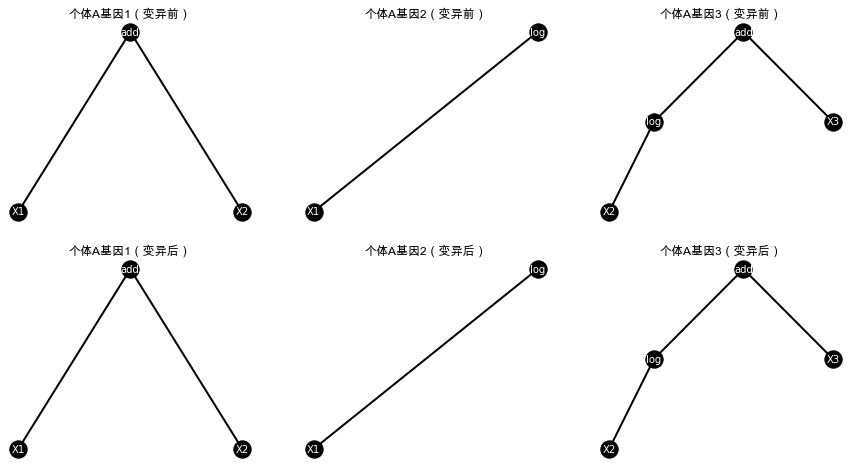

In [19]:
import pandas as pd
iris = pd.read_csv("http://image.cador.cn/data/iris.csv")
pre_A = A.copy()
mutate(None,[A],0.9,iris,[1,2,3,4])
# 0 mutate on -->  2
counter = 1
titles=['个体A基因1（变异前）','个体A基因2（变异前）','个体A基因3（变异前）','个体A基因1（变异后）','个体A基因2（变异后）','个体A基因3（变异后）']
plt.figure(figsize=(15,8))
for e in pre_A+A:
    plt.subplot(2,3,counter)
    plot_tree(e, title=titles[counter - 1],node_size=300,font_size=10)
    counter = counter + 1
plt.show()